#### 1. Acitivity of Zebra Fish and Melatonin
In this study, the researchers in Prof. Prober's lab studied the activity of zebrafish larvae. Each fish was put in its own little well and recorded with a camera. Whenever a fish moves, the system detects and records the movement, indicated here by the red flashes in the video. The more movement, the more wakeful the fish.

These fish are interesting because some of them have a mutation in a gene involved in producing melatonin, an important hormone for sleep regulation. Fish that have the mutation are called mutants, and those that do not are called wild type. If we look at the mean activity of the fish over time, we see that compared to wild type the mutant fish are more active at night, which is indicated by the gray regions on the plot. Our goal with this warm-up analysis is to quantify the effect of this mutation on wakefulness. 

We will use nighttime active bouts as a metric for wakefulness of the fish. An active bout is a period of time where a fish is consistently active. The *length* of an active bout is the number of consecutive minutes that a fish is active. 
Generically speaking, a probability distribution is a mathematical description of outcomes. But they are easier to think about as stories. Here, I will review the Exponential distribution. Its story has to do with Poisson processes. For a Poisson process, the timing of an event, called an "arrival," is completely independent of when the previous event arrived. The waiting time between arrivals is Exponentially distributed.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dc_stat_think as dcst # module containing all functions we used in 1_statistical_thinking and 2_statistical thinking

#### EDA: Plot ECDFs of active bout length
An active bout is a stretch of time where a fish is constantly moving. Plot an ECDF of active bout length for the mutant and wild type fish for the seventh night of their lives. The data sets are in the numpy arrays bout_lengths_wt and bout_lengths_mut. The bout lengths are in units of minutes.

In [2]:
df = pd.read_csv('gandhi_et_al_bouts.csv')

In [3]:
df.head()

,genotype,bout_length,fish
0,het,12.00,1
1,het,33.00,1
2,het,0.96,1
3,het,4.98,1
4,het,1.98,1


In [4]:
## Selecting the columns from the dataframe that will be used to plot the ecdf
bout_lengths_wt = df[df['genotype'] == 'wt']['bout_length'].to_numpy()
bout_lengths_mut = df[df['genotype'] == 'mut']['bout_length'].to_numpy()

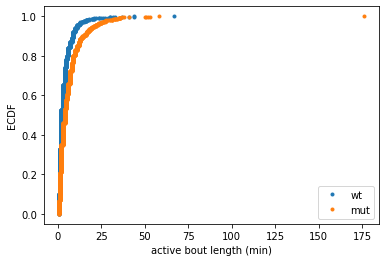

In [5]:
# Import the dc_stat_think module as dcst
import dc_stat_think as dcst

# Generate x and y values for plotting ECDFs
x_wt, y_wt = dcst.ecdf(bout_lengths_wt)
x_mut, y_mut = dcst.ecdf(bout_lengths_mut)

# Plot the ECDFs
_ = plt.plot(x_wt, y_wt, marker = '.', linestyle = 'none')
_ = plt.plot(x_mut, y_mut, marker = '.', linestyle = 'none')

# Make a legend, label axes, and show plot
_ = plt.legend(('wt', 'mut'))
_ = plt.xlabel('active bout length (min)')
_ = plt.ylabel('ECDF')
plt.show()

Great work! There is an outlier of one active bout for a mutant fish, and the ECDF exposes this clearly. It is important to know about, but we will not focus on it going forward, though.

#### Interpreting ECDFs and the story
While a more detailed analysis of distributions is often warranted for careful analyses, you can already get a feel for the distributions and the story behind the data by eyeballing the ECDFs. 

The bout lengths appear Exponentially distributed, which implies that exiting an active bout to rest is a Poisson process; the fish have no apparent memory about when they became active.

While not exactly Exponentially distributed, the ECDF has no left tail, and no discernible inflection point, which is very much like the Exponential CDF.

#### Parameter estimation: active bout length
Compute the mean active bout length for wild type and mutant, with 95% bootstrap confidence interval. The data sets are again available in the numpy arrays bout_lengths_wt and bout_lengths_mut. The dc_stat_think module has been imported as dcst.

In [6]:
# Compute mean active bout length
mean_wt = np.mean(bout_lengths_wt)
mean_mut = np.mean(bout_lengths_mut)

# Draw bootstrap replicates
bs_reps_wt = dcst.draw_bs_reps(bout_lengths_wt, np.mean, size = 10000)
bs_reps_mut = dcst.draw_bs_reps(bout_lengths_mut, np.mean, size = 10000)

# Compute 95% confidence intervals
conf_int_wt = np.percentile(bs_reps_wt, [2.5, 97.5])
conf_int_mut = np.percentile(bs_reps_mut, [2.5, 97.5])

# Print the results
print("""
wt:  mean = {0:.3f} min., conf. int. = [{1:.1f}, {2:.1f}] min.
mut: mean = {3:.3f} min., conf. int. = [{4:.1f}, {5:.1f}] min.
""".format(mean_wt, *conf_int_wt, mean_mut, *conf_int_mut))


wt:  mean = 3.874 min., conf. int. = [3.6, 4.1] min.
mut: mean = 6.543 min., conf. int. = [6.1, 7.0] min.



The confidence intervals are quite separated. Nonetheless, we will proceed to perform hypothesis tests.

#### Permutation and Bootstrap Hypothesis Tests
You just found that the mean active bout length for mutant fish that have inhibited melatonin production is much longer than for wild type fish that have normal melatonin production.
This is especially clear if we look at the confidence intervals graphically. Obviously, there is an effect on activity due to mutation of this gene. 

In addition to mutant fish, Prof. Prober's lab also studied heterozygotic fish. These are fish that have one mutated copy of the gene and one functional copy, unlike the mutant, which has two mutated copies, or wild type, which has two functional copies. When we do the same analysis of the heterozygote, we see that the effect is much smaller. Indeed, if we look at the ECDFs of active bout length, here with the x-axis range adjusted for ease of comparison, we see only a slight difference between the wild type and heterozygotic fish. We have quantified the differences, and we can see them graphically, but now is a good time to test the hypothesis that there is no difference between the heterozygotic and wild type fish. 

A hypothesis test is an assessment of how reasonable the observed data are assuming a hypothesis, called the null hypothesis, is true. The result of a hypothesis test is a p-value, defined as the probability of obtaining a value of your test statistic that is at least as extreme as what was observed, under the assumption the null hypothesis is true. As a reminder, a test statistic is a single number that can be computed from observed data and from data you simulate under the null hypothesis to serve as a basis of comparison.
The p-value only makes sense if the null hypothesis, test statistic, and the meaning of "at least as extreme as" are clearly defined. So, the pipeline for doing a hypothesis test is to clearly state the null hypothesis and the test statistic. Then you *simulate* production of the data as if the null hypothesis were true. For each of these simulated data sets, compute the test statistic. The p-value is then the fraction of your simulated data sets for which the test statistic is at least as extreme as for the real data. Let's consider now the hypothesis that the active bout lengths of wild type and heterozygotic fish are identically distributed. We will use the difference in means of the active bout lengths as a test statistic, and consider test statistics greater than or equal to what was observed to be "at least as extreme as." 

The hypothesis says that wild type and heterozygotic fish are completely indistinguishable with respect to their active bout lengths. To simulate this, you can scramble which bout lengths are labeled "wild type" and which are labeled "heterozygote" and compute the test statistic. You do this over and over again to get many permutation replicates. This is called a *permutation test*. You implemented this in the `draw_perm_reps()` function of the `dc_stat_think` module. The first two arguments are the two data sets you are comparing in the hypothesis test. The third argument is a function used to compute the test statistic. You already wrote one to do difference of means, and it is also included in the `dc_stat_think` module. The last argument says how many replicates to generate. Finally, the p-value is computed as the fraction of replicates at least as extreme as what was observed.

#### Permutation test: wild type versus heterozygote
Test the hypothesis that the heterozygote and wild type bout lengths are identically distributed using a permutation test.

In [7]:
#Extracing the bout length for the heterozygote fish
bout_lengths_het = df[df['genotype'] == 'het']['bout_length']

In [8]:
# Compute the difference of means: diff_means_exp
diff_means_exp = np.mean(bout_lengths_het) - np.mean(bout_lengths_wt)

# Draw permutation replicates: perm_reps
perm_reps = dcst.draw_perm_reps(bout_lengths_het, bout_lengths_wt, 
                               dcst.diff_of_means, size = 10000)

# Compute the p-value: p-val
p_val = np.sum(perm_reps >= diff_means_exp) / len(perm_reps)

# Print the result
print('p =', p_val)

p = 0.0008


A p-value of 0.001 suggests that the observed difference in means is unlikely to occur if heterozygotic and wild type fish have active bout lengths that are identically distributed.

#### Bootstrap hypothesis test
The permutation test has a pretty restrictive hypothesis, that the heterozygotic and wild type bout lengths are identically distributed. Now, use a bootstrap hypothesis test to test the hypothesis that the means are equal, making no assumptions about the distributions.

In [9]:
# Concatenate arrays: bout_lengths_concat
bout_lengths_concat = np.concatenate((bout_lengths_wt, bout_lengths_het))

# Compute mean of all bout_lengths: mean_bout_length
mean_bout_length = np.mean(bout_lengths_concat)

# Generate shifted arrays
wt_shifted = bout_lengths_wt - np.mean(bout_lengths_wt) + mean_bout_length
het_shifted = bout_lengths_het - np.mean(bout_lengths_het) + mean_bout_length

# Compute 10,000 bootstrap replicates from shifted arrays
bs_reps_wt = dcst.draw_bs_reps(wt_shifted, np.mean, size = 10000)
bs_reps_het = dcst.draw_bs_reps(het_shifted, np.mean, size = 10000)

# Get replicates of difference of means: bs_replicates
bs_reps = bs_reps_het - bs_reps_wt

# Compute and print p-value: p
p = np.sum(bs_reps >= diff_means_exp) / len(bs_reps)
print('p-value =', p)

p-value = 0.0006


We get a result of similar magnitude as the permutation test, though slightly smaller, probably because the heterozygote bout length distribution has a heavier tail to the right.

#### Linear Regressions and Pairs Bootstrap
Sometimes variables are related to each other and a linear relationship is appropriate for the data. In these cases, a linear regression is useful to quantify the relationship between two related variables. To practice performing linear regressions, we will consider another data set from the biological sciences at Caltech, this time from the lab of Michael Elowitz. Here is a movie of two bacteria of the species *Bacillus subtilis* growing and dividing into a small colony. These bacteria were engineered to have fluorescent proteins in them, which is why they glow, enabling us to see them clearly. If I plot the total area of bacteria in the image over time, we see this beautiful growth curve. This is clearly not a linear curve, though. However, if I instead plot the logarithm of the bacterial area versus time, the curve is linear. This is accomplished using the `plt.semilogy()` function, which works just like `plt.plot()`, but with the y-axis on a logarithmic scale. The slope of the growth curve on a semilog plot is the growth rate of the bacteria.

In the second Statistical Thinking course, you learned how to perform a linear regression using `np.polyfit()`. The first two arguments are the respective x and y values you want to fit with a line. The last argument is always one for a linear regression because a line is a polynomial of degree one. The function returns the slope and intercept of the best fit line. You can then generate points to use to plot a theoretical line, and can finally put it all together on a plot. The problem is that we need to perform the regression using the *logarithm* of the bacterial area. We now use `np.log()` to pass the logarithm of the bacterial area into `np.polyfit()`. When computing the theoretical area, we exponentiate the theoretical curve using `np.exp()` to recover the area in square micrometers. 

Finally, we make our plots using `plt.semilogy()`. Now, you might already be thinking of the next question. If we did this experiment again, how might the growth rate we obtain change? Or more specifically, what is the 95% confidence interval of the growth rate? Pairs bootstrap is an approach to compute confidence intervals for regression parameters. Instead of resampling a single data set, as we did before, we resample *pairs* of data. In this case, we take a time point and its corresponding bacterial area, store it, and then select another time point-bacterial area pair, and so on with replacement. We then compute the slope and intercept from the resampled data to get a pairs bootstrap replicate. We do this over and over again and then compute the confidence interval from percentiles of the replicates.You wrote a function called `draw_bs_pairs_linreg()` to do this in Statistical Thinking Part II, and it is also implemented in the `dc_stat_think` module. Given x and y data, as well as the number of replicates you want via the `size` keyword argument, it returns pairs bootstrap replicates of the slope and intercept. You can then compute the confidence interval from the replicates using the `np.percentile()` function.


#### Assessing the growth rate
To compute the growth rate, you can do a linear regression of the logarithm of the total bacterial area versus time. Compute the growth rate and get a 95% confidence interval using pairs bootstrap. The time points, in units of hours, are stored in the numpy array `t` and the bacterial area, in units of square micrometers, is stored in `bac_area`.

In [10]:
### Getting the relevant columns from the dataset 
bacteria_growth = pd.read_csv('park_bacterial_growth.csv')


t = bacteria_growth['time (hr)'].to_numpy()
bac_area = bacteria_growth['bacterial area (sq. microns)'].to_numpy()

In [11]:
# Compute logarithm of the bacterial area: log_bac_area
log_bac_area = np.log(bac_area)

# Compute the slope and intercept: growth_rate, log_a0
growth_rate, log_a0 = np.polyfit(t, log_bac_area, 1)

# Draw 10,000 pairs bootstrap replicates: growth_rate_bs_reps, log_a0_bs_reps
growth_rate_bs_reps, log_a0_bs_reps = dcst.draw_bs_pairs_linreg(
    t, log_bac_area, size = 10000
)
    
# Compute confidence intervals: growth_rate_conf_int
growth_rate_conf_int = np.percentile(growth_rate_bs_reps, [2.5, 97.5])

# Print the result to the screen
print("""
Growth rate: {0:.4f} 1/hour
95% conf int: [{1:.4f}, {2:.4f}] 1/hour
""".format(growth_rate, *growth_rate_conf_int))


Growth rate: 0.2301 1/hour
95% conf int: [0.2266, 0.2336] 1/hour



Under these conditions, the bacterial mass doubles about every three hours. The error bar is very tight, which we will see graphically in the next cell.

#### Plotting the growth curve
The confidence interval on the growth curve is very tight. You will explore this graphically here by plotting several bootstrap lines along with the growth curve. You will use the plt.semilogy() function to make the plot with the y-axis on a log scale. This means that you will need to transform your theoretical linear regression curve for plotting by exponentiating it.

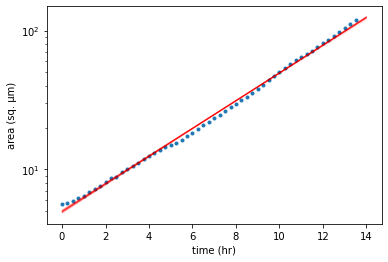

In [12]:
# Plot data points in a semilog-y plot with axis labeles
_ = plt.semilogy(t, bac_area, marker='.', linestyle='none')

# Generate x-values for the bootstrap lines: t_bs
t_bs = np.array([0, 14])

# Plot the first 100 bootstrap lines
for i in range(100):
    y = np.exp(growth_rate_bs_reps[i] * t_bs + log_a0_bs_reps[i])
    _ = plt.semilogy(t_bs, y, linewidth=0.5, alpha=0.05, color='red')
    
# Label axes and show plot
_ = plt.xlabel('time (hr)')
_ = plt.ylabel('area (sq. µm)')
plt.show()

You can see that the bootstrap replicates do not stray much. This is due to the exquisitly exponential nature of the bacterial growth under these experimental conditions.

#### 2. Analysis of results of the 2015 FINA World Swimming Championships

#### The 2015 FINA World Championships
We will work with swimming races from the 2015 FINA World Championships in Kazan, Russia, which took place in this pool. Before we plunge into the data, I need to bring you up to speed with some background on swimming competitions. First let's look at the pool. If you count, you will notice that there are ten lanes in the pool. Like Python arrays, the lanes are zero-indexed, going from zero to nine. Races are typically swum in lanes one through eight. The pool is 50 meters long, so in events longer than 50 meters, the swimmers turn around at the ends of the pool. There are four different strokes, or ways of swimming, and each have their own competitions. They are freestyle, breaststroke, butterfly, and backstroke. It is important to note that because of the differences in the mechanics of the strokes, they are swum at different speeds. You can think of each event at the World Championships as being defined by unique a tuple of a gender, distance, and stroke. For example, in your first exercises, you will look at results of the men's 200 m freestyle. Each event is swum in stages, called rounds, with the fastest swimmers from each round progressing in the competition. The first round is referred to as heats. In events of longer distance, the fastest eight swimmers from the heats advance to compete in the finals, the winner of which is the champion. Shorter distance events have a semifinal round, where the fastest 16 swimmers from the heats race in the semifinals, and the fastest eight of those advance to the final. Finally, I want to mention that the data we will use in this case study are freely available from the Swiss company OMEGA, the official timekeepers of the World Championships. 

#### Graphical EDA of men's 200 free heats
In the heats, all contestants swim, the very fast and the very slow. To explore how the swim times are distributed, plot an ECDF of the men's 200 freestyle.

In [15]:
mens_200_free_heats = np.array([118.32, 107.73, 107.  , 106.39, 108.75, 117.74, 108.43, 111.96,
       114.36, 121.77, 108.23, 107.47, 118.41, 108.29, 106.  , 109.32,
       111.49, 112.92, 117.38, 110.95, 108.27, 111.78, 107.87, 110.77,
       109.05, 111.  , 108.77, 106.1 , 106.61, 113.68, 108.2 , 106.2 ,
       111.01, 109.25, 112.  , 118.55, 109.56, 108.18, 111.67, 108.09,
       110.04, 113.97, 109.91, 112.12, 111.65, 110.18, 116.36, 124.59,
       115.59, 121.01, 106.88, 108.96, 109.09, 108.67, 109.6 , 111.85,
       118.54, 108.12, 124.38, 107.17, 107.48, 106.65, 106.91, 140.68,
       117.93, 120.66, 111.29, 107.1 , 108.49, 112.43, 110.61, 110.38,
       109.87, 106.73, 107.18, 110.98, 108.55, 114.31, 112.05])

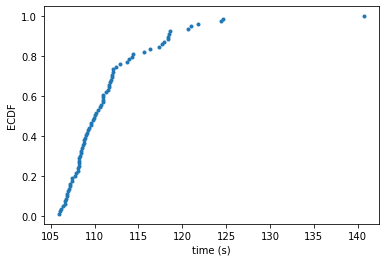

In [16]:
# Generate x and y values for ECDF: x, y
x, y = dcst.ecdf(mens_200_free_heats)

# Plot the ECDF as dots
_= plt.plot(x, y, marker = '.', linestyle = 'none')

# Label axes and show plot
plt.xlabel('time (s)')
plt.ylabel('ECDF')
plt.show()

Graphical EDA is always a great start. We see that fast swimmers are below 115 seconds, with a smattering of slow swimmers past that, including one very slow swimmer.

#### 200 m free time with confidence interval
Now, you will practice parameter estimation and computation of confidence intervals by computing the mean and median swim time for the men's 200 freestyle heats. The median is useful because it is immune to heavy tails in the distribution of swim times, such as the slow swimmers in the heats.

In [17]:
# Compute mean and median swim times
mean_time = np.mean(mens_200_free_heats)
median_time = np.median(mens_200_free_heats)

# Draw 10,000 bootstrap replicates of the mean and median
bs_reps_mean = dcst.draw_bs_reps(mens_200_free_heats, np.mean, size = 10000)
bs_reps_median = dcst.draw_bs_reps(mens_200_free_heats, np.median, size = 10000)


# Compute the 95% confidence intervals
conf_int_mean = np.percentile(bs_reps_mean, [2.5, 97.5])
conf_int_median = np.percentile(bs_reps_median, [2.5, 97.5])

# Print the result to the screen
print("""
mean time: {0:.2f} sec.
95% conf int of mean: [{1:.2f}, {2:.2f}] sec.

median time: {3:.2f} sec.
95% conf int of median: [{4:.2f}, {5:.2f}] sec.
""".format(mean_time, *conf_int_mean, median_time, *conf_int_median))


mean time: 111.63 sec.
95% conf int of mean: [110.51, 112.94] sec.

median time: 110.04 sec.
95% conf int of median: [108.96, 111.29] sec.



Indeed, the mean swim time is longer than the median because of the effect of the very slow swimmers.

#### Do swimmers go faster in the finals?
Anecdotally, it seems like swimmers swim faster in the finals. For example, all of the personal best times of the great American swimmer Michael Phelps occurred in the final round of a competition. 

Similarly, as of summer 2017, the personal bests another great swimmer, Sarah Sjöström of Sweden, all occurred in a final, except for one semifinal. 

This raises the question, do swimmers swim faster in the finals than in other rounds? At face, this seems like a reasonable question, but we have to be more precise. Let's think about some issues we need to resolve to make our question clear. First, which swimmers are we talking about? For example, we could compare average swim time in the finals versus in the semifinals. But only the best swimmers swim in the finals, so on average, they will be faster. So, we should compare the performance of individual swimmers from round to round. Second, against what rounds will we compare? A problem is that elite swimmers sometimes do not give everything they have in the heats because the competition is weak and they want to have more energy for the finals. So, a better comparison is for individual swimmers between semifinals to finals. Finally, do we want to make this comparison for a given stroke, or for all strokes together? And for what distances? So, we see that posing the statistical question is a crucial, and sometimes difficult, first step in an analysis. Let's be more specific in our question, then.

Do individual female swimmers swim faster in the finals compared to the semifinals? Implicit in this question is that we will include all events that have semifinals, which are the shorter distance events in each of the strokes.

We are almost ready to do the analysis, but we have another issue to think about. As I mentioned before, each stroke is swum at a different pace. Furthermore, the improvement from semifinals to finals for each distance may vary as well, with larger gains possible at longer distances. So, we have to come up with a metric for improvement from semifinals to finals that is unaffected by these inherent differences in events.

A reasonable metric is the *fractional improvement* from the semifinals to the finals. By normalizing the difference in time by the semifinal time, we mitigate the effects of different strokes and different distances.

So, we no longer ask the original yes or no question, but a quantitative one. "What is the fractional improvement of individual female swimmers from the semifinals to the finals? "The icing on the cake is the hypothesis test. "Is the observed fractional improvement commensurate with there being no difference in performance between the semifinals and finals?" This process of carefully posing a question to ask of your data is a key part of any analysis.

#### EDA: finals versus semifinals
First, you will get an understanding of how athletes' performance changes from the semifinals to the finals by computing the fractional improvement from the semifinals to finals and plotting an ECDF of all of these values.

The arrays final_times and semi_times contain the swim times of the respective rounds. The arrays are aligned such that `final_times[i]` and `semi_times[i]` are for the same swimmer/event. If you are interested in the strokes/events, you can check out the data frame df in your namespace, which has more detailed information, but is not used in the analysis.

In [19]:
final_times = np.array([ 52.52,  24.12,  52.82,  24.36,  57.67, 116.41,  58.26,  27.66,
       125.81,  58.75,  27.92, 126.78,  25.93,  24.44,  27.26,  58.22,
       128.66,  24.39,  57.69, 143.61, 128.51,  30.74,  59.02,  27.11,
        57.85,  66.55, 142.76,  57.48,  25.37, 116.27,  54.76, 126.51,
        27.58, 130.2 , 142.76,  57.05,  25.34,  58.86,  27.73,  25.78,
       142.76,  25.85,  24.51,  59.78,  27.99,  57.94, 126.78, 128.49,
        28.17, 116.19, 126.84, 127.76, 129.53,  67.1 ,  31.12, 115.32,
        67.6 ,  66.42,  30.11, 125.56,  66.43, 141.15, 143.19,  66.36,
        30.14, 116.79,  53.58,  53.17,  24.22,  25.64,  26.2 , 116.16,
       127.64,  65.66,  30.13,  59.66, 143.59,  55.64,  52.7 ,  24.96,
        24.31,  67.17,  30.05,  31.14,  53.93,  24.57, 142.44, 115.16,
        59.4 , 115.49,  54.  , 126.34,  30.2 , 126.95,  59.99, 126.4 ])

semi_times = np.array([ 53.  ,  24.32,  52.84,  24.22,  57.59, 116.95,  58.56,  27.7 ,
       126.56,  59.05,  27.83, 127.57,  25.81,  24.38,  27.41,  58.05,
       128.99,  24.52,  57.52, 142.82, 128.16,  31.03,  59.33,  27.18,
        57.63,  66.28, 143.06,  57.36,  25.79, 116.44,  53.91, 127.08,
        27.67, 127.69, 141.99,  57.04,  25.27,  58.84,  27.63,  25.88,
       142.9 ,  25.71,  24.5 ,  59.71,  27.88,  57.77, 126.64, 129.16,
        28.01, 116.51, 126.18, 127.05, 129.04,  67.11,  30.9 , 116.23,
        66.95,  66.21,  30.78, 126.36,  66.64, 142.15, 142.88,  65.64,
        29.98, 116.91,  53.38,  53.78,  24.23,  25.9 ,  25.91, 116.56,
       128.74,  65.6 ,  30.14,  59.55, 142.72,  55.74,  52.78,  25.06,
        24.31,  66.76,  30.39,  30.64,  53.81,  24.47, 142.04, 116.76,
        59.42, 116.37,  53.92, 127.79,  30.25, 127.52,  59.63, 127.57])

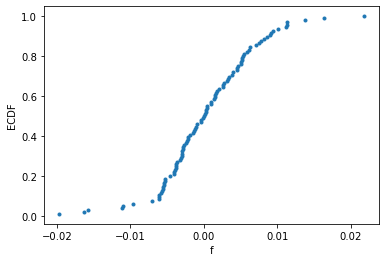

In [22]:
# Compute fractional difference in time between finals and semis
f = (semi_times - final_times) / semi_times

# Generate x and y values for the ECDF: x, y
x, y = dcst.ecdf(f)


# Make a plot of the ECDF
_= plt.plot(x, y, marker = '.', linestyle = 'none')

# Label axes and show plot
_ = plt.xlabel('f')
_ = plt.ylabel('ECDF')
plt.show()

The median of the ECDF is just above zero. But at first glance, it does not look like there is much of any difference between semifinals and finals. We'll check this carefully in the next exercises.

#### Parameter estimates of difference between finals and semifinals
Compute the mean fractional improvement from the semifinals to finals, along with a 95% confidence interval of the mean. The Numpy array f that you computed in the last exercise is in your namespace.

In [23]:
# Mean fractional time difference: f_mean
f_mean = np.mean(f)

# Get bootstrap reps of mean: bs_reps
bs_reps = dcst.draw_bs_reps(f, np.mean, 10000)

# Compute confidence intervals: conf_int
conf_int = np.percentile(bs_reps, [2.5, 97.5])

# Report
print("""
mean frac. diff.: {0:.5f}
95% conf int of mean frac. diff.: [{1:.5f}, {2:.5f}]""".format(f_mean, *conf_int))


mean frac. diff.: 0.00040
95% conf int of mean frac. diff.: [-0.00095, 0.00172]


It looks like the mean finals time is just faster than the mean semifinal time, and they very well may be the same. We'll test this hypothesis next.